In [1]:
from gptopt.optim.linop import *
from gptopt.optim.least_squares_torchmin import *
from gptopt.optim.attn_kq import * 
from utils import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

from gptopt.utils import set_seed
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Comparison of methods to solve
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2
\end{array} 
$$

## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right )  
\end{aligned}
$$


In [3]:
n_layer = 4
std1 = 0.02 / np.sqrt(2.0 * n_layer)
std2 = 0.01
rank_ratio = 0.7
max_iter = 1000

betas = [ 1e-3, 5e-4, 1e-4]

#  $m=50, ~n=10, ~h=5$

In [4]:
n_head = 5
m = 50
n = 10

In [5]:
A2, A1, G1, G2 = gaussian_data_heads(m, n, n_head=n_head, std1=std1, std2=std2, 
                                            rank_ratio=rank_ratio, G_in_range=True, dtype=torch.float64)
beta = 0.01

A_linop = attn_linop_from_matrices_heads(A1, A2, n_head=n_head)
Grad = Z1_Z2_pack_Z_heads(G1, G2, n_head=n_head)
lamb_max = A_linop.fro_norm

mu_reg = 0

print(f"{lamb_max=:.4e}")

lamb_max=2.2527e-01


In [ ]:
Z_star, f_star, Y_star = cvxpy_A_linop_heads(Grad.cpu().numpy(), A_linop, beta, n_head=n_head)

In [7]:
Y_star_torch = torch.tensor(Y_star, dtype=A1.dtype, device=device)
Z_star_torch = torch.tensor(Z_star, dtype=A2.dtype, device=device) 
pd_residuals_max_ball_linop(A_linop, Y_star_torch, Z_star_torch, Grad, beta, mu_reg)

(8.090538673961696e-08,
 3.6181988899138717e-07,
 3.2054439941471447e-19,
 1.7567893677946034e-16)

In [8]:
Y0, res_lsmr_y, itn_y = solve_lsmr_Y_lstsq(A_linop, Grad, n_head=n_head)
Z0, res_lsmr_z, itn_z = solve_lsmr_Z_lstsq(A_linop, beta, Y0, n_head=n_head)

print(f"{res_lsmr_y=:.4e}, {res_lsmr_z=:.4e}, {itn_y=}, {itn_z=}")
pd_residuals_max_ball_linop(A_linop, Y0, Z0, Grad, beta, mu_reg)

res_lsmr_y=1.0586e-08, res_lsmr_z=1.1743e-08, itn_y=20, itn_z=20


(0.44721359549995754,
 1.999999999999998,
 1.9315772206103365e-11,
 1.058628486549286e-08)

In [9]:
# Torch prox for h* (uses prox_l1 from pdhg.py)
prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
h_conj = lambda y: beta * torch.abs(y).sum()

In [10]:
func_obj = lambda Z: (Grad * Z).sum().item()  
func_constr_viol = lambda Z: max(torch.max(torch.abs(A_linop.mv(Z))).item() - beta, 0) / beta

In [11]:
print(
    f"{f_star=:.4e}, "
    f"{func_obj(Z_star_torch)}, "
    f"\ncvxpy constraint violation: "
    f"{func_constr_viol(Z_star_torch)}"
) 

f_star=-4.8751e-03, -0.004875100360448969, 
cvxpy constraint violation: 0.0


In [12]:
residuals = compare_methods_fast_pdhg(prox_h_conj, h_conj, A_linop, Grad, beta, mu_reg, f_star=f_star, 
                            stopping=False, max_iter=1000, eps_abs=1e-5)

Method                 Obj          Viol
----------------------------------------
pdhg          -4.692031e-03  2.553283e-03
rehpdhg       -4.692430e-03  5.454902e-04
pdhg ds       -4.864658e-03  3.775014e-04
rehpdhg ds    -4.251086e-03  1.546758e-02
ada rehpdhg   -3.681856e-03  4.699793e-04
ada rehpdhg ds  -4.856166e-03  3.158972e-05


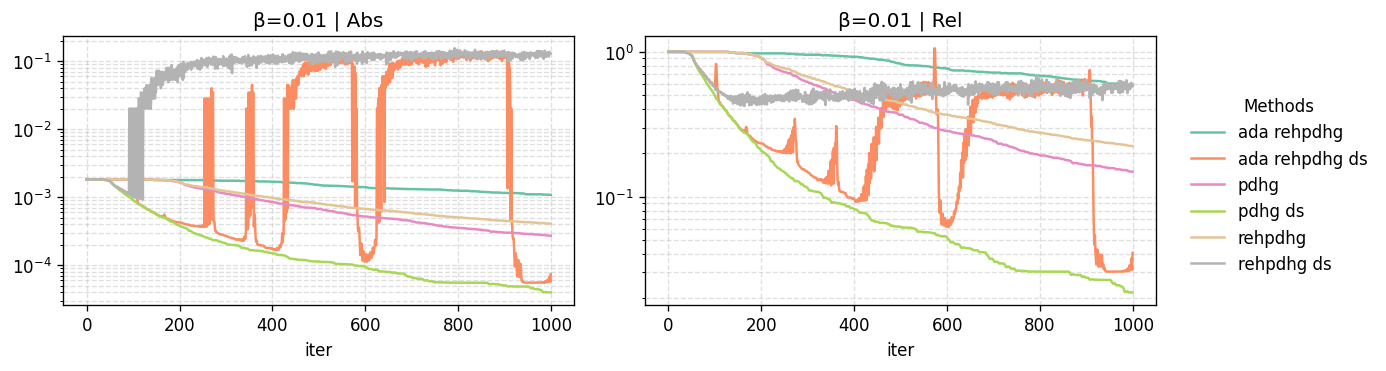

In [13]:
_ = plot_residuals_grid_by_param({beta:residuals}, 
                                #  abs_ylim=(1e-3, 5), rel_ylim=(1e-4, 1.5), 
                                 param_name='beta')

In [14]:
# cupdlp r1 is large probably due to rounding of Y and the corresponding sign(Y) 

#  $m=768, ~n=64, ~h=12$

In [15]:
m = 768
n_head = 12
n = 64 * n_head

In [16]:
std2 = 1 
std1 = 1
rank_ratio = 0.5
A2, A1, G1, G2 = gaussian_data_heads(m, n, n_head=n_head, std1=std1, std2=std2, 
                                            rank_ratio=rank_ratio, G_in_range=True)

A_linop = attn_linop_from_matrices_heads(A1, A2, n_head=n_head)
Grad = Z1_Z2_pack_Z_heads(G1, G2, n_head=n_head)
lamb_max = A_linop.fro_norm

print(f"{lamb_max=:.4e}")

lamb_max=1.0868e+03


In [17]:
residuals = {}
for beta in betas:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    mu_reg = 0
    print(f"{beta=}, {lamb_max=:.4e}")
    residuals[beta] = compare_methods_fast_pdhg(prox_h_conj, h_conj, A_linop, Grad, beta, mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-6)

beta=0.001, lamb_max=1.0868e+03
Method                 Obj          Viol
----------------------------------------
pdhg          -2.654702e+01  1.404594e+01
rehpdhg       -1.944420e+01  4.819744e+00
pdhg ds       -4.667197e+01  2.564489e+01
rehpdhg ds    -2.085226e+01  5.611572e+00
ada rehpdhg   -9.142648e+00  2.151457e+00
ada rehpdhg ds  -9.196439e+00  1.546123e+00
beta=0.0005, lamb_max=1.0868e+03
Method                 Obj          Viol
----------------------------------------
pdhg          -2.654702e+01  2.909188e+01
rehpdhg       -1.484114e+01  9.677910e+00
pdhg ds       -4.667197e+01  5.228978e+01
rehpdhg ds    -1.624816e+01  1.131132e+01
ada rehpdhg   -4.529149e+00  4.267260e+00
ada rehpdhg ds  -4.586712e+00  3.401430e+00
beta=0.0001, lamb_max=1.0868e+03
Method                 Obj          Viol
----------------------------------------
pdhg          -2.654702e+01  1.494594e+02
rehpdhg       -1.115761e+01  4.791484e+01
pdhg ds       -4.667197e+01  2.654489e+02
rehpdhg ds    -1.25649

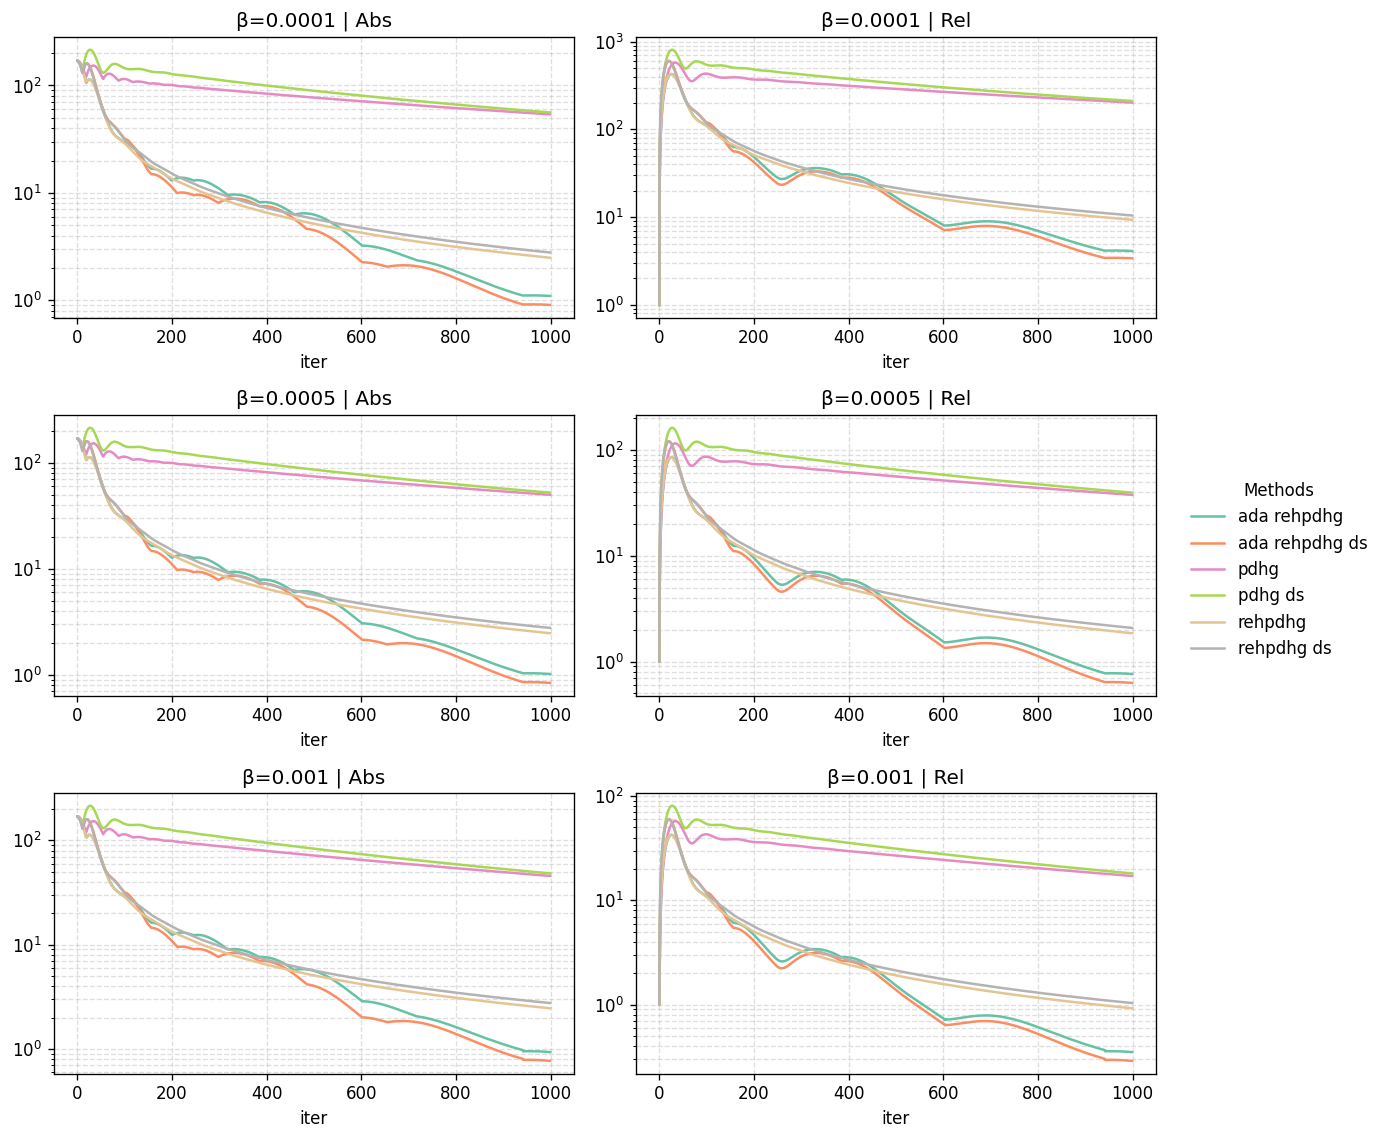

In [18]:
_ = plot_residuals_grid_by_param(residuals, 
                                #  abs_ylim=(1e-3, 5), rel_ylim=(1e-4, 1.5), 
                                 param_name='beta')